In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from haversine import haversine

import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, Activation, Dropout, Lambda
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

### 数据处理

In [3]:
df=pd.read_excel('datasets/raw_data.xlsx')
# plt.figure(figsize=(15, 5))
# plt.plot(df['时间'], df['压力'])
# plt.title('压力随时间变化图')
# plt.xlabel('时间')
# plt.ylabel('压力')
# plt.show()

In [1]:
data=df
data['季节']=df['月'].apply(lambda x: '春' if x in [3,4,5] else ('夏' if x in [6,7,8] else ('秋' if x in [9,10,11] else '冬')))
data['降雨量等级'] = pd.cut(data['降雨量'], bins=[-1, 30, 60, 90, 120,150], labels=[1,2,3,4,5])

NameError: name 'df' is not defined

In [7]:
import pandas as pd
from haversine import haversine, Unit

# 标准化经度值
def normalize_lon(lon):
    if lon > 180:
        lon -= 360
    elif lon < -180:
        lon += 360
    return lon

# 检查经纬度是否在合理范围内
def check_coordinates(group):
    group['经度'] = group['经度'].apply(normalize_lon)
    valid_group = group[(group['纬度'] >= -90) & (group['纬度'] <= 90) &
                        (group['经度'] >= -180) & (group['经度'] <= 180)]
    return valid_group

# 计算每个时间点的影响面积
def calculate_impact_area(row):
    intensity = row['强度标记']
    # 假设台风影响范围与等级的公式：R=10⋅Vm^0.5
    ls = {
        0: 10,  # 假设弱于热带低压的最大风速为10 m/s
        1: 17.1,  # 热带低压的最大风速上限
        2: 24.4,  # 热带风暴的最大风速上限
        3: 32.6,  # 强热带风暴的最大风速上限
        4: 41.4,  # 台风的最大风速上限
        5: 50.9,  # 强台风的最大风速上限
        6: 51.0,  # 超强台风的最小风速
        9: 10,  # 假设变性台风的最大风速为10 m/s
    }
    impact_radius = 10 * (ls[intensity] ** 0.5)  # 假设每单位强度标记对应100平方公里
    return impact_radius

# 计算每个移动段的影响面积
def calculate_segment_impact_area(row1, row2):
    intensity1 = row1['强度标记']
    intensity2 = row2['强度标记']
    impact_radius1 = calculate_impact_area(row1)
    impact_radius2 = calculate_impact_area(row2)
    distance = haversine((row1['纬度'], row1['经度']), (row2['纬度'], row2['经度']), unit=Unit.KILOMETERS)
    segment_impact_area = (impact_radius1 + impact_radius2) * distance
    return segment_impact_area

# 累加所有移动段的影响面积
def calculate_total_impact_area(df):
    total_impact_area = 0
    for i in range(len(df) - 1):
        total_impact_area += calculate_segment_impact_area(df.iloc[i], df.iloc[i + 1])
    return total_impact_area

# 定义一个函数来处理每组的数据
def process_group(group):
    # 检查经纬度是否在合理范围内
    group = check_coordinates(group)
    
    form_dt = group['时间'].min()
    dispear_dt = group['时间'].max()
    peak_idx = group['强度标记'].idxmax()
    peak_dt = group.loc[peak_idx, '时间']
    lifespan = (dispear_dt - form_dt).total_seconds()
    
    # 计算路径长度
    def calculate_path_length(df):
        total_distance = 0
        for i in range(len(df) - 1):
            lat1, lon1 = df.iloc[i]['纬度'], df.iloc[i]['经度']
            lat2, lon2 = df.iloc[i + 1]['纬度'], df.iloc[i + 1]['经度']
            distance = haversine((lat1, lon1), (lat2, lon2), unit=Unit.KILOMETERS)
            total_distance += distance
        return total_distance
    
    path_length = calculate_path_length(group)
    
    # 使用新的函数计算总影响面积
    total_impact_area = calculate_total_impact_area(group)
    
    return pd.Series([form_dt, dispear_dt, peak_dt, lifespan, path_length, total_impact_area],
                     index=['form_dt', 'dispear_dt', 'peak_dt', 'lifespan', 'path_length', 'impact_area'])

# 应用函数到每个分组
result = data.groupby('英文名称').apply(process_group).reset_index()

# 查看结果
result.head(20)

,英文名称,form_dt,dispear_dt,peak_dt,lifespan,path_length,impact_area
0,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.720530,201113.726007
1,2,2012-11-12 00:00:00,2012-11-15 18:00:00,2012-11-12 06:00:00,324000.0,1563.593747,125352.667220
2,3,2013-08-17 00:00:00,2013-09-19 00:00:00,2013-08-17 00:00:00,2851200.0,3315.095981,274172.667685
3,4,2013-10-17 06:00:00,2013-10-22 06:00:00,2013-10-17 06:00:00,432000.0,2708.271446,223985.673873
4,5,2013-11-03 00:00:00,2013-11-07 18:00:00,2013-11-03 00:00:00,410400.0,3496.089751,289141.629395
5,6,2014-03-22 00:00:00,2014-03-24 06:00:00,2014-03-22 00:00:00,194400.0,912.244759,68310.793436
6,7,2014-08-18 12:00:00,2014-08-21 00:00:00,2014-08-18 12:00:00,216000.0,2272.467412,187942.809550
7,8,2014-09-06 06:00:00,2014-09-08 06:00:00,2014-09-06 06:00:00,172800.0,844.879910,69875.195256
8,9,2015-07-23 00:00:00,2015-07-25 18:00:00,2015-07-23 06:00:00,237600.0,799.579221,63933.782051
9,10,2015-12-16 12:00:00,2016-05-28 06:00:00,2015-12-17 00:00:00,14148000.0,3606.973892,272160.339378


In [9]:
# 将影响面积列与原始数据拼接
merged_data = data.merge(result, on='英文名称', how='left')
merged_data.head(20)

,时间,年,月,日,小时,强度标记,纬度,经度,压力,OWD,...,英文名称,降雨量,季节,降雨量等级,form_dt,dispear_dt,peak_dt,lifespan,path_length,impact_area
0,2012-02-14 18:00:00,2012,2,14,18,1,7.9,130.2,1004,16,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
1,2012-02-15 00:00:00,2012,2,15,0,1,8.9,128.4,1004,16,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
2,2012-02-15 06:00:00,2012,2,15,6,1,9.6,127.2,1004,16,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
3,2012-02-15 12:00:00,2012,2,15,12,1,10.2,125.8,1006,16,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
4,2012-02-15 18:00:00,2012,2,15,18,1,11.0,124.5,1006,16,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
5,2012-02-16 00:00:00,2012,2,16,0,1,10.5,123.0,1006,13,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
6,2012-02-16 06:00:00,2012,2,16,6,1,9.8,121.7,1006,13,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
7,2012-02-16 12:00:00,2012,2,16,12,1,9.5,120.4,1006,13,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
8,2012-02-16 18:00:00,2012,2,16,18,1,9.5,118.8,1006,13,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007
9,2012-02-17 00:00:00,2012,2,17,0,1,9.5,117.0,1006,16,...,1,0.0,冬,1,2012-02-14 18:00:00,2012-02-21 06:00:00,2012-02-14 18:00:00,561600.0,2431.72053,201113.726007


In [10]:
merged_data.to_csv('merged_data_new.csv',encoding='gbk')

### 分析

#### T&P检验

In [7]:
# 比较不同季节的压力差异
seasons=['春','夏','秋','冬']
for i in range(len(seasons)):
    for j in range(i + 1, len(seasons)):
        season1 = seasons[i]
        season2 = seasons[j]

        # 提取每个季节的压力数据
        pressure1 = data[data['季节'] == season1]['压力']
        pressure2 = data[data['季节'] == season2]['压力']

        # 计算样本量
        n1 = len(pressure1)
        n2 = len(pressure2)

        # 执行 t 检验
        t_stat, p_val = stats.ttest_ind(pressure1, pressure2)

        # 打印结果
        print(f'比较 {season1} 和 {season2}:')
        print(f't-statistic: {t_stat}')
        print(f'p-value: {p_val}')
        print(f'样本量: {n1} vs {n2}')

        # 分析结果
        if n1 < 30 or n2 < 30:
            print('注意: 样本量较小，可能影响结果可靠性')

        # 根据 t 统计量和 p 值给出结论
        if p_val < 0.05:
            if abs(t_stat) > 2:
                conclusion = '显著差异（强烈）'
            elif abs(t_stat) > 1:
                conclusion = '显著差异（中等）'
            else:
                conclusion = '显著差异（弱）'
        else:
            conclusion = '无显著差异'

        print(f'结论: 季节 {season1} 和 {season2} 的压力存在 {conclusion}')
        print()

比较 春 和 夏:
t-statistic: 3.591467563914326
p-value: 0.00033464186148333925
样本量: 423 vs 2300
结论: 季节 春 和 夏 的压力存在 显著差异（强烈）

比较 春 和 秋:
t-statistic: 5.679619469537211
p-value: 1.5035297166158646e-08
样本量: 423 vs 2120
结论: 季节 春 和 秋 的压力存在 显著差异（强烈）

比较 春 和 冬:
t-statistic: 0.04366493698601249
p-value: 0.9651817681372586
样本量: 423 vs 427
结论: 季节 春 和 冬 的压力存在 无显著差异

比较 夏 和 秋:
t-statistic: 4.484216702148322
p-value: 7.503798597931916e-06
样本量: 2300 vs 2120
结论: 季节 夏 和 秋 的压力存在 显著差异（强烈）

比较 夏 和 冬:
t-statistic: -3.480523101655284
p-value: 0.0005082972346547442
样本量: 2300 vs 427
结论: 季节 夏 和 冬 的压力存在 显著差异（强烈）

比较 秋 和 冬:
t-statistic: -5.5565290449361955
p-value: 3.0378217412902207e-08
样本量: 2120 vs 427
结论: 季节 秋 和 冬 的压力存在 显著差异（强烈）



In [8]:
# 比较不同季节的OWD差异
seasons=['春','夏','秋','冬']
for i in range(len(seasons)):
    for j in range(i + 1, len(seasons)):
        season1 = seasons[i]
        season2 = seasons[j]

        # 提取每个季节的压力数据
        pressure1 = data[data['季节'] == season1]['OWD']
        pressure2 = data[data['季节'] == season2]['OWD']

        # 计算样本量
        n1 = len(pressure1)
        n2 = len(pressure2)

        # 执行 t 检验
        t_stat, p_val = stats.ttest_ind(pressure1, pressure2)

        # 打印结果
        print(f'比较 {season1} 和 {season2}:')
        print(f't-statistic: {t_stat}')
        print(f'p-value: {p_val}')
        print(f'样本量: {n1} vs {n2}')

        # 分析结果
        if n1 < 30 or n2 < 30:
            print('注意: 样本量较小，可能影响结果可靠性')

        # 根据 t 统计量和 p 值给出结论
        if p_val < 0.05:
            if abs(t_stat) > 2:
                conclusion = '显著差异（强烈）'
            elif abs(t_stat) > 1:
                conclusion = '显著差异（中等）'
            else:
                conclusion = '显著差异（弱）'
        else:
            conclusion = '无显著差异'

        print(f'结论: 季节 {season1} 和 {season2} 的OWD存在 {conclusion}')
        print()

比较 春 和 夏:
t-statistic: -3.1816775087272102
p-value: 0.001480738098409179
样本量: 423 vs 2300
结论: 季节 春 和 夏 的OWD存在 显著差异（强烈）

比较 春 和 秋:
t-statistic: -5.5130331058121325
p-value: 3.8825346705689085e-08
样本量: 423 vs 2120
结论: 季节 春 和 秋 的OWD存在 显著差异（强烈）

比较 春 和 冬:
t-statistic: -0.536372759256885
p-value: 0.5918416268718923
样本量: 423 vs 427
结论: 季节 春 和 冬 的OWD存在 无显著差异

比较 夏 和 秋:
t-statistic: -4.7070562044363475
p-value: 2.590112852631738e-06
样本量: 2300 vs 2120
结论: 季节 夏 和 秋 的OWD存在 显著差异（强烈）

比较 夏 和 冬:
t-statistic: 2.457149058256334
p-value: 0.014066354333488478
样本量: 2300 vs 427
结论: 季节 夏 和 冬 的OWD存在 显著差异（强烈）

比较 秋 和 冬:
t-statistic: 4.8354888903803905
p-value: 1.4073290626205997e-06
样本量: 2120 vs 427
结论: 季节 秋 和 冬 的OWD存在 显著差异（强烈）



In [9]:
# 比较不同季节的压力差异
seasons=['春','夏','秋','冬']
for i in range(len(seasons)):
    for j in range(i + 1, len(seasons)):
        season1 = seasons[i]
        season2 = seasons[j]

        # 提取每个季节的压力数据
        pressure1 = data[data['季节'] == season1]['降雨量']
        pressure2 = data[data['季节'] == season2]['降雨量']

        # 计算样本量
        n1 = len(pressure1)
        n2 = len(pressure2)

        # 执行 t 检验
        t_stat, p_val = stats.ttest_ind(pressure1, pressure2)

        # 打印结果
        print(f'比较 {season1} 和 {season2}:')
        print(f't-statistic: {t_stat}')
        print(f'p-value: {p_val}')
        print(f'样本量: {n1} vs {n2}')

        # 分析结果
        if n1 < 30 or n2 < 30:
            print('注意: 样本量较小，可能影响结果可靠性')

        # 根据 t 统计量和 p 值给出结论
        if p_val < 0.05:
            if abs(t_stat) > 2:
                conclusion = '显著差异（强烈）'
            elif abs(t_stat) > 1:
                conclusion = '显著差异（中等）'
            else:
                conclusion = '显著差异（弱）'
        else:
            conclusion = '无显著差异'

        print(f'结论: 季节 {season1} 和 {season2} 的降雨量存在 {conclusion}')
        print()

比较 春 和 夏:
t-statistic: -5.012905088448393
p-value: 5.705455096643611e-07
样本量: 423 vs 2300
结论: 季节 春 和 夏 的降雨量存在 显著差异（强烈）

比较 春 和 秋:
t-statistic: -3.3067306130399605
p-value: 0.0009570530472743999
样本量: 423 vs 2120
结论: 季节 春 和 秋 的降雨量存在 显著差异（强烈）

比较 春 和 冬:
t-statistic: -4.247368622067779
p-value: 2.4022505604223593e-05
样本量: 423 vs 427
结论: 季节 春 和 冬 的降雨量存在 显著差异（强烈）

比较 夏 和 秋:
t-statistic: 6.758298759451747
p-value: 1.5779094740530193e-11
样本量: 2300 vs 2120
结论: 季节 夏 和 秋 的降雨量存在 显著差异（强烈）

比较 夏 和 冬:
t-statistic: 4.908716991340986
p-value: 9.707920789673738e-07
样本量: 2300 vs 427
结论: 季节 夏 和 冬 的降雨量存在 显著差异（强烈）

比较 秋 和 冬:
t-statistic: 3.0676524770521914
p-value: 0.0021801856233937245
样本量: 2120 vs 427
结论: 季节 秋 和 冬 的降雨量存在 显著差异（强烈）



#### K-Means

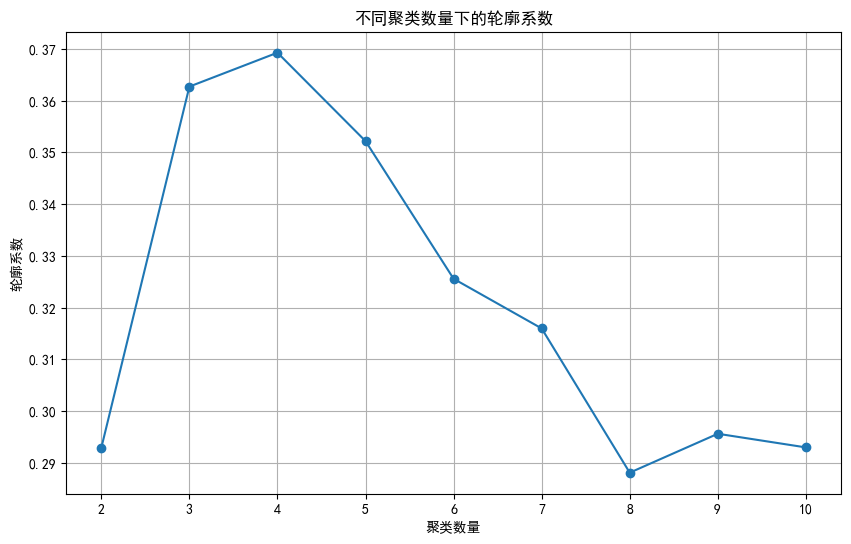

最佳聚类数量: 4, 轮廓系数: 0.3693


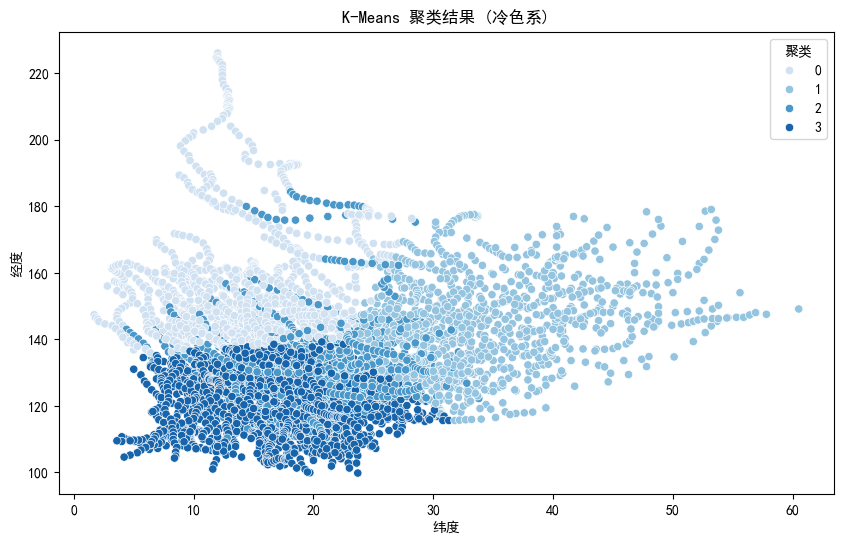

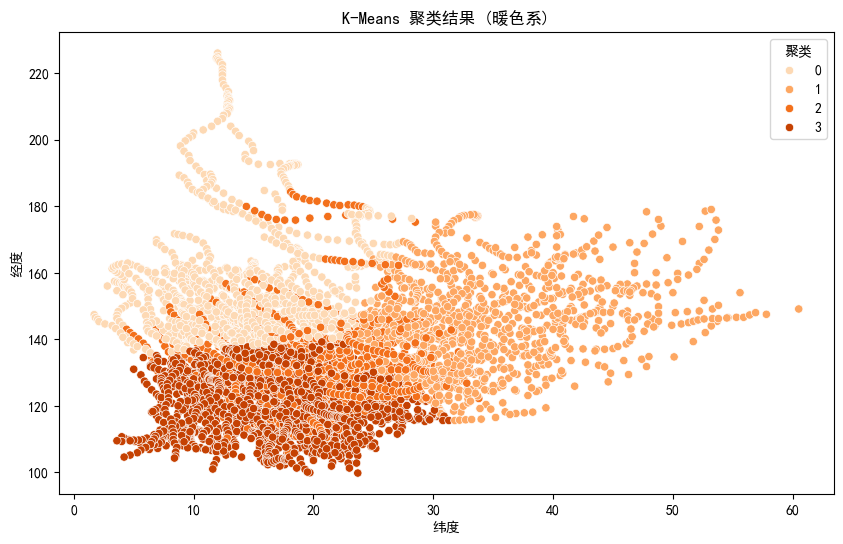

In [25]:
# 选择特征
features = ['纬度', '经度', '压力']
X = data[features]

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 循环比较不同聚类数量的效果
best_num_clusters = None
best_silhouette_score = -1
silhouette_scores = []

for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_
    
    # 计算轮廓系数
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # 更新最佳聚类数量
    if silhouette_avg > best_silhouette_score:
        best_num_clusters = num_clusters
        best_silhouette_score = silhouette_avg

# 可视化轮廓系数
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('聚类数量')
plt.ylabel('轮廓系数')
plt.title('不同聚类数量下的轮廓系数')
plt.grid(True)
plt.show()

# 最佳聚类数量
print(f'最佳聚类数量: {best_num_clusters}, 轮廓系数: {best_silhouette_score:.4f}')

# 使用最佳聚类数量重新进行 K-Means 聚类
kmeans_best = KMeans(n_clusters=best_num_clusters, random_state=42)
kmeans_best.fit(X_scaled)
cluster_labels_best = kmeans_best.labels_
data['cluster'] = cluster_labels_best

# 冷色系配色方案
plt.figure(figsize=(10, 6))
sns.scatterplot(x='纬度', y='经度', hue='cluster', data=data, palette=sns.color_palette("Blues", n_colors=best_num_clusters))
plt.xlabel('纬度')
plt.ylabel('经度')
plt.title('K-Means 聚类结果 (冷色系)')
plt.legend(title='聚类')
plt.show()

# 暖色系配色方案
plt.figure(figsize=(10, 6))
sns.scatterplot(x='纬度', y='经度', hue='cluster', data=data, palette=sns.color_palette("Oranges", n_colors=best_num_clusters))
plt.xlabel('纬度')
plt.ylabel('经度')
plt.title('K-Means 聚类结果 (暖色系)')
plt.legend(title='聚类')
plt.show()

### TCN

In [4]:
merged_data=pd.read_excel('datasets/data_merge_precip.xlsx')
numeric_columns = merged_data.select_dtypes(include=['int64', 'float64']).columns
merged_data[numeric_columns] = (merged_data[numeric_columns] - merged_data[numeric_columns].mean()) / merged_data[numeric_columns].std()
merged_data.head()

,时间,year,month,day,小时,强度标记,纬度,经度,压力,OWD,...,降雨量,季节,降雨量等级,form_dt,dispear_dt,peak_dt,lifespan,path_length,impact_area,日降雨量
0,2012/2/14 18:00,-1.454211,-2.671492,-0.187608,1.347590,-0.922061,-1.356085,-0.268730,0.895211,-0.73908,...,-0.188911,冬,-0.10265,2012/2/14 18:00,2012/2/21 6:00,2012/2/14 18:00,-0.309011,-0.969617,-1.123516,-0.288494
1,2012/2/15 0:00,-1.454211,-2.671492,-0.073083,-1.331661,-0.922061,-1.248864,-0.365162,0.895211,-0.73908,...,-0.188911,冬,-0.10265,2012/2/14 18:00,2012/2/21 6:00,2012/2/14 18:00,-0.309011,-0.969617,-1.123516,-0.541277
2,2012/2/15 6:00,-1.454211,-2.671492,-0.073083,-0.438577,-0.922061,-1.173809,-0.429449,0.895211,-0.73908,...,-0.188911,冬,-0.10265,2012/2/14 18:00,2012/2/21 6:00,2012/2/14 18:00,-0.309011,-0.969617,-1.123516,-0.256652
3,2012/2/15 12:00,-1.454211,-2.671492,-0.073083,0.454507,-0.922061,-1.109477,-0.504452,0.983454,-0.73908,...,-0.188911,冬,-0.10265,2012/2/14 18:00,2012/2/21 6:00,2012/2/14 18:00,-0.309011,-0.969617,-1.123516,0.410724
4,2012/2/15 18:00,-1.454211,-2.671492,-0.073083,1.347590,-0.922061,-1.023700,-0.574097,0.983454,-0.73908,...,-0.188911,冬,-0.10265,2012/2/14 18:00,2012/2/21 6:00,2012/2/14 18:00,-0.309011,-0.969617,-1.123516,1.865124


Epoch 1/100
66/66 [==============================] - 3s 19ms/step - loss: 2530862.2500 - val_loss: 2526124.2500 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 1s 13ms/step - loss: 2486030.2500 - val_loss: 2462777.0000 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 1s 18ms/step - loss: 2433955.2500 - val_loss: 2376216.5000 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 1s 15ms/step - loss: 2373249.0000 - val_loss: 2311430.0000 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 1s 14ms/step - loss: 2301442.5000 - val_loss: 2251878.7500 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 1s 15ms/step - loss: 2222474.7500 - val_loss: 2164883.5000 - lr: 0.0010
Epoch 7/100
66/66 [==============================] - 1s 15ms/step - loss: 2134495.2500 - val_loss: 2093000.3750 - lr: 0.0010
Epoch 8/100
66/66 [==============================] - 1s 15ms/step - loss: 2039045.2500 - val_loss: 2005052.7500 - lr: 0.0010


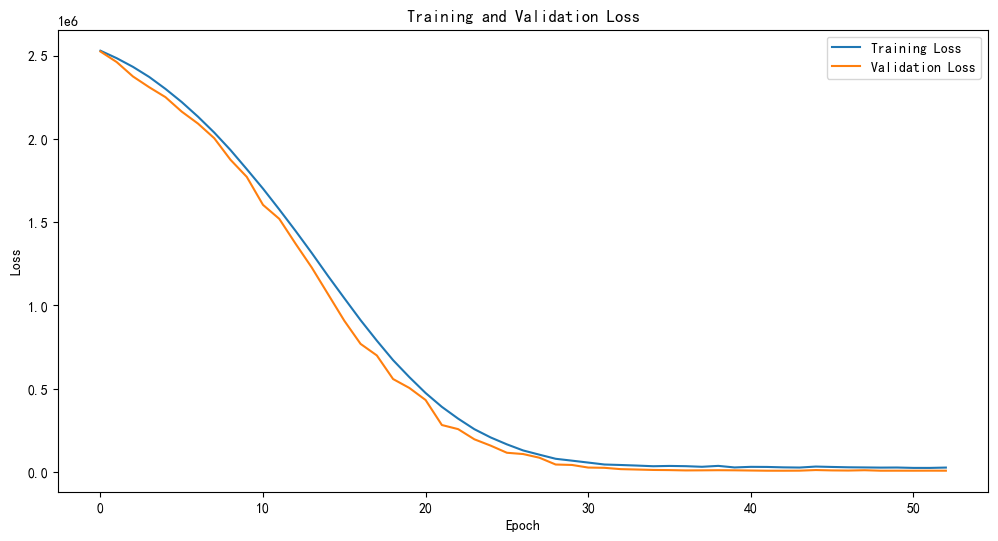

Mean Squared Error (MSE): 6587.988830239798
Mean Absolute Error (MAE): 44.485896155919974
R² Score: 0.5008502892047719


KeyboardInterrupt: 

In [12]:
# 调参
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 假设 merged_data 是已经处理好的 DataFrame
# 分离特征和目标变量
X = merged_data.drop(['降雨量', 'impact_area'], axis=1)
y = merged_data[['降雨量', 'impact_area']]

# 删除非数值类型的列
non_numeric_columns = X.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns
X = X.drop(non_numeric_columns, axis=1)

# 将所有时间相关的列转换为 Unix 时间戳
timestamp_columns = ['时间', 'form_dt', 'dispear_dt', 'peak_dt']
for col in timestamp_columns:
    if col in X.columns:
        X[col] = X[col].apply(lambda x: x.timestamp() if isinstance(x, pd.Timestamp) else x)

# 将 DataFrame 转换为 numpy 数组
X = X.values
y = y.values

# 数据预处理：标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将特征数据重塑为3维数组，以适应TCN模型的输入格式
time_steps = 5
num_features = X_train.shape[1]

X_train_reshaped = np.zeros((X_train.shape[0] - time_steps + 1, time_steps, num_features))
X_test_reshaped = np.zeros((X_test.shape[0] - time_steps + 1, time_steps, num_features))

for i in range(X_train_reshaped.shape[0]):
    X_train_reshaped[i, :, :] = X_train[i:i + time_steps, :]

for i in range(X_test_reshaped.shape[0]):
    X_test_reshaped[i, :, :] = X_test[i:i + time_steps, :]

# 调整 y_train 和 y_test 的长度
y_train = y_train[time_steps - 1:]
y_test = y_test[time_steps - 1:]

# 定义 TCN 模型
def create_tcn_model(input_shape, num_filters, kernel_size, dilations, num_outputs, dropout_rate, regularizer):
    model = Sequential()

    model.add(Conv1D(filters=num_filters, kernel_size=1, padding='same', input_shape=input_shape, kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for dilation_rate in dilations:
        model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(num_outputs, kernel_regularizer=regularizer))

    return model

# 模型参数
input_shape = (time_steps, num_features)
num_filters = 64  # 增加卷积层的数量
kernel_size = 3
dilations = [1, 2, 4, 8, 16, 32]
dropout_rate = 0.2  # 减小 Dropout 率
num_outputs = y_train.shape[1]
regularizer = l2(0.001)

# 构建和编译模型
tcn_tensorflow_model = create_tcn_model(input_shape, num_filters, kernel_size, dilations, num_outputs, dropout_rate, regularizer)
tcn_tensorflow_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # 调整学习率

# 设置早停
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 学习率衰减
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# 训练模型
history = tcn_tensorflow_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,  # 增加批次大小
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 打印模型摘要
tcn_tensorflow_model.summary()

# 保存模型
tcn_tensorflow_model.save('tcn_model.h5')

# 可视化训练结果
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 模型评估
y_pred = tcn_tensorflow_model.predict(X_test_reshaped)

# 计算评价指标
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

# 调参
param_grid = {
    'num_filters': [32, 64, 128],
    'kernel_size': [2, 3, 4],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1]
}

def create_and_compile_model(num_filters, kernel_size, dropout_rate, learning_rate):
    model = create_tcn_model(input_shape, num_filters, kernel_size, dilations, num_outputs, dropout_rate, regularizer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# 使用 KerasClassifier 包装模型
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

keras_classifier = KerasClassifier(build_fn=create_and_compile_model, epochs=100, batch_size=64, verbose=0)

# 使用 GridSearchCV 进行调参
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train_reshaped, y_train)

# 输出最佳参数
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 使用最佳参数重新训练模型
best_num_filters = grid_result.best_params_['num_filters']
best_kernel_size = grid_result.best_params_['kernel_size']
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_learning_rate = grid_result.best_params_['learning_rate']

best_model = create_tcn_model(input_shape, best_num_filters, best_kernel_size, dilations, num_outputs, best_dropout_rate, regularizer)
best_model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='mse')

best_history = best_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 保存最佳模型
best_model.save('best_tcn_model.h5')

# 可视化最佳模型训练结果
plt.figure(figsize=(12, 6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100
66/66 [==============================] - 3s 18ms/step - loss: 1.6751 - val_loss: 1.2368 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 1s 13ms/step - loss: 0.9667 - val_loss: 1.0791 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 1s 12ms/step - loss: 0.6837 - val_loss: 0.7647 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 1s 15ms/step - loss: 0.5627 - val_loss: 0.4855 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 1s 15ms/step - loss: 0.5023 - val_loss: 0.3889 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 1s 15ms/step - loss: 0.4596 - val_loss: 0.3584 - lr: 0.0010
Epoch 7/100
66/66 [==============================] - 1s 15ms/step - loss: 0.4384 - val_loss: 0.3429 - lr: 0.0010
Epoch 8/100
66/66 [==============================] - 1s 14ms/step - loss: 0.4104 - val_loss: 0.3380 - lr: 0.0010
Epoch 9/100
66/66 [==============================] - 1s 14ms/step - loss: 0.3972 - val_loss: 0.3

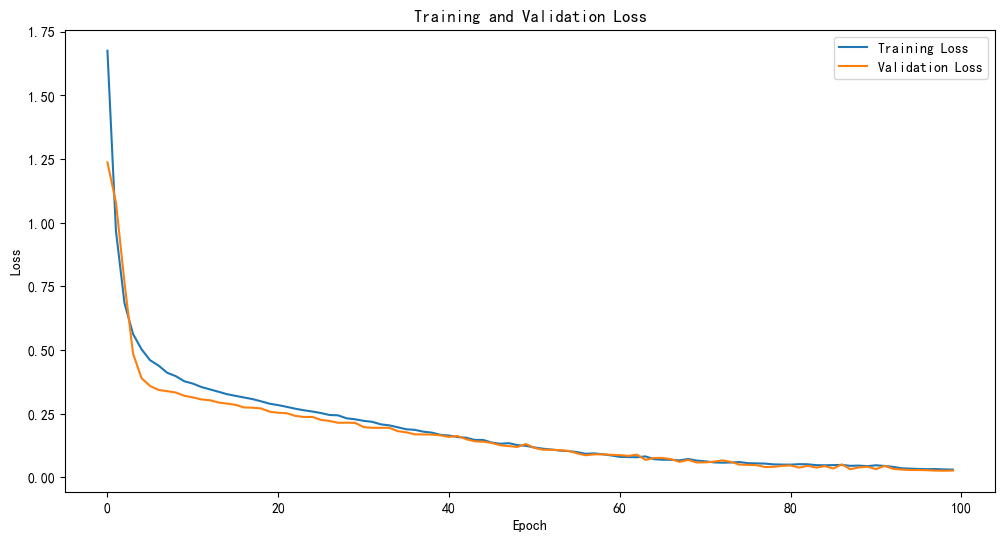

Mean Squared Error (MSE): 0.010407397315896464
Mean Absolute Error (MAE): 0.08008100135242723
R² Score: 0.9889396142310485


In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 假设 merged_data 是已经处理好的 DataFrame
# 分离特征和目标变量
X = merged_data.drop(['impact_area'], axis=1)
y = merged_data[['impact_area']]

# 删除非数值类型的列
non_numeric_columns = X.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns
X = X.drop(non_numeric_columns, axis=1)

# 将所有时间相关的列转换为 Unix 时间戳
timestamp_columns = ['时间', 'form_dt', 'dispear_dt', 'peak_dt']
for col in timestamp_columns:
    if col in X.columns:
        X[col] = X[col].apply(lambda x: x.timestamp() if isinstance(x, pd.Timestamp) else x)

# 将 DataFrame 转换为 numpy 数组
X = X.values
y = y.values

# 数据预处理：标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将特征数据重塑为3维数组，以适应TCN模型的输入格式
time_steps = 5
num_features = X_train.shape[1]

X_train_reshaped = np.zeros((X_train.shape[0] - time_steps + 1, time_steps, num_features))
X_test_reshaped = np.zeros((X_test.shape[0] - time_steps + 1, time_steps, num_features))

for i in range(X_train_reshaped.shape[0]):
    X_train_reshaped[i, :, :] = X_train[i:i + time_steps, :]

for i in range(X_test_reshaped.shape[0]):
    X_test_reshaped[i, :, :] = X_test[i:i + time_steps, :]

# 调整 y_train 和 y_test 的长度
y_train = y_train[time_steps - 1:]
y_test = y_test[time_steps - 1:]

# 定义 TCN 模型
def create_tcn_model(input_shape, num_filters, kernel_size, dilations, num_outputs, dropout_rate, regularizer):
    model = Sequential()

    model.add(Conv1D(filters=num_filters, kernel_size=1, padding='same', input_shape=input_shape, kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for dilation_rate in dilations:
        model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(num_outputs, kernel_regularizer=regularizer))

    return model

# 模型参数
input_shape = (time_steps, num_features)
num_filters = 64  # 增加卷积层的数量
kernel_size = 3
dilations = [1, 2, 4, 8, 16, 32]
dropout_rate = 0.1  # 减小 Dropout 率
num_outputs = y_train.shape[1]
regularizer = l2(0.001)

# 构建和编译模型
tcn_tensorflow_model = create_tcn_model(input_shape, num_filters, kernel_size, dilations, num_outputs, dropout_rate, regularizer)
tcn_tensorflow_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # 调整学习率

# 设置早停
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 学习率衰减
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# 训练模型
history = tcn_tensorflow_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,  # 增加批次大小
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 打印模型摘要
tcn_tensorflow_model.summary()

# 保存模型
tcn_tensorflow_model.save('tcn_model.h5')

# 可视化训练结果
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 模型评估
y_pred = tcn_tensorflow_model.predict(X_test_reshaped)

# 计算评价指标
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')


Epoch 1/100
66/66 [==============================] - 4s 18ms/step - loss: 1.4039 - val_loss: 1.1992 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 1s 15ms/step - loss: 0.7560 - val_loss: 0.9344 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 1s 12ms/step - loss: 0.5977 - val_loss: 0.6590 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 1s 12ms/step - loss: 0.5049 - val_loss: 0.4678 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 1s 14ms/step - loss: 0.4596 - val_loss: 0.3824 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 1s 14ms/step - loss: 0.4358 - val_loss: 0.3419 - lr: 0.0010
Epoch 7/100
66/66 [==============================] - 1s 14ms/step - loss: 0.4113 - val_loss: 0.3285 - lr: 0.0010
Epoch 8/100
66/66 [==============================] - 1s 15ms/step - loss: 0.3918 - val_loss: 0.3263 - lr: 0.0010
Epoch 9/100
66/66 [==============================] - 1s 14ms/step - loss: 0.3764 - val_loss: 0.3

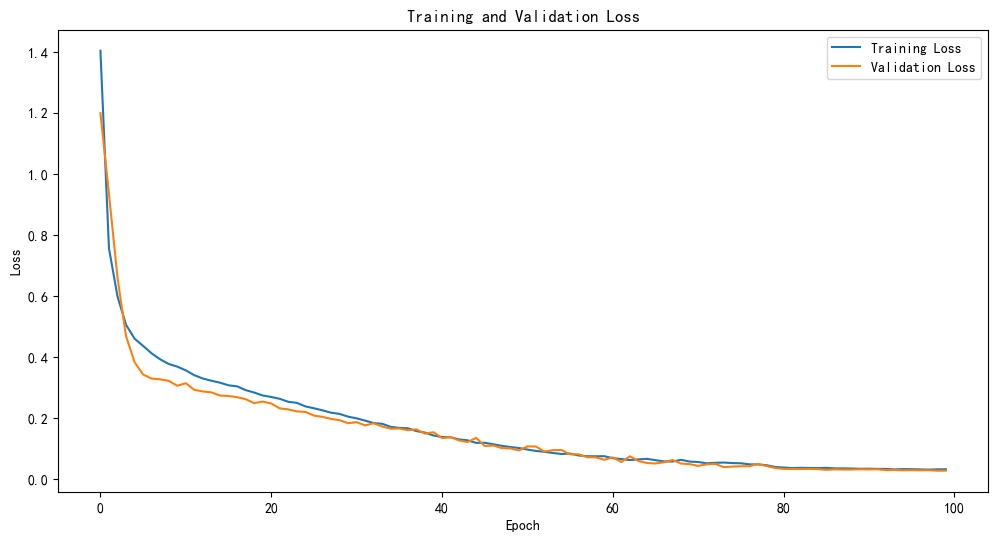

Mean Squared Error (MSE): 0.010920396375983127
Mean Absolute Error (MAE): 0.08073387811242659
R² Score: 0.9883944282131193


In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 假设 merged_data 是已经处理好的 DataFrame
# 分离特征和目标变量
X = merged_data.drop(['impact_area'], axis=1)
y = merged_data[['impact_area']]

# 删除非数值类型的列
non_numeric_columns = X.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns
X = X.drop(non_numeric_columns, axis=1)

# 将所有时间相关的列转换为 Unix 时间戳
timestamp_columns = ['时间', 'form_dt', 'dispear_dt', 'peak_dt']
for col in timestamp_columns:
    if col in X.columns:
        X[col] = X[col].apply(lambda x: x.timestamp() if isinstance(x, pd.Timestamp) else x)

# 将 DataFrame 转换为 numpy 数组
X = X.values
y = y.values

# 数据预处理：标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将特征数据重塑为3维数组，以适应TCN模型的输入格式
time_steps = 5
num_features = X_train.shape[1]

X_train_reshaped = np.zeros((X_train.shape[0] - time_steps + 1, time_steps, num_features))
X_test_reshaped = np.zeros((X_test.shape[0] - time_steps + 1, time_steps, num_features))

for i in range(X_train_reshaped.shape[0]):
    X_train_reshaped[i, :, :] = X_train[i:i + time_steps, :]

for i in range(X_test_reshaped.shape[0]):
    X_test_reshaped[i, :, :] = X_test[i:i + time_steps, :]

# 调整 y_train 和 y_test 的长度
y_train = y_train[time_steps - 1:]
y_test = y_test[time_steps - 1:]

# 定义 TCN 模型
def create_tcn_model(input_shape, num_filters, kernel_size, dilations, num_outputs, dropout_rate, regularizer):
    model = Sequential()

    model.add(Conv1D(filters=num_filters, kernel_size=1, padding='same', input_shape=input_shape, kernel_regularizer=regularizer))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for dilation_rate in dilations:
        model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='same', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(num_outputs, kernel_regularizer=regularizer))

    return model

# 模型参数
input_shape = (time_steps, num_features)
num_filters = 64  # 增加卷积层的数量
kernel_size = 3
dilations = [1, 2, 4, 8, 16, 32]
dropout_rate = 0.1  # 减小 Dropout 率
num_outputs = y_train.shape[1]
regularizer = l2(0.001)

# 构建和编译模型
tcn_tensorflow_model = create_tcn_model(input_shape, num_filters, kernel_size, dilations, num_outputs, dropout_rate, regularizer)
tcn_tensorflow_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # 调整学习率

# 设置早停
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 学习率衰减
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# 训练模型
history = tcn_tensorflow_model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,  # 增加批次大小
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 打印模型摘要
tcn_tensorflow_model.summary()

# 保存模型
tcn_tensorflow_model.save('tcn_model.h5')

# 可视化训练结果
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 模型评估
y_pred = tcn_tensorflow_model.predict(X_test_reshaped)

# 计算评价指标
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')


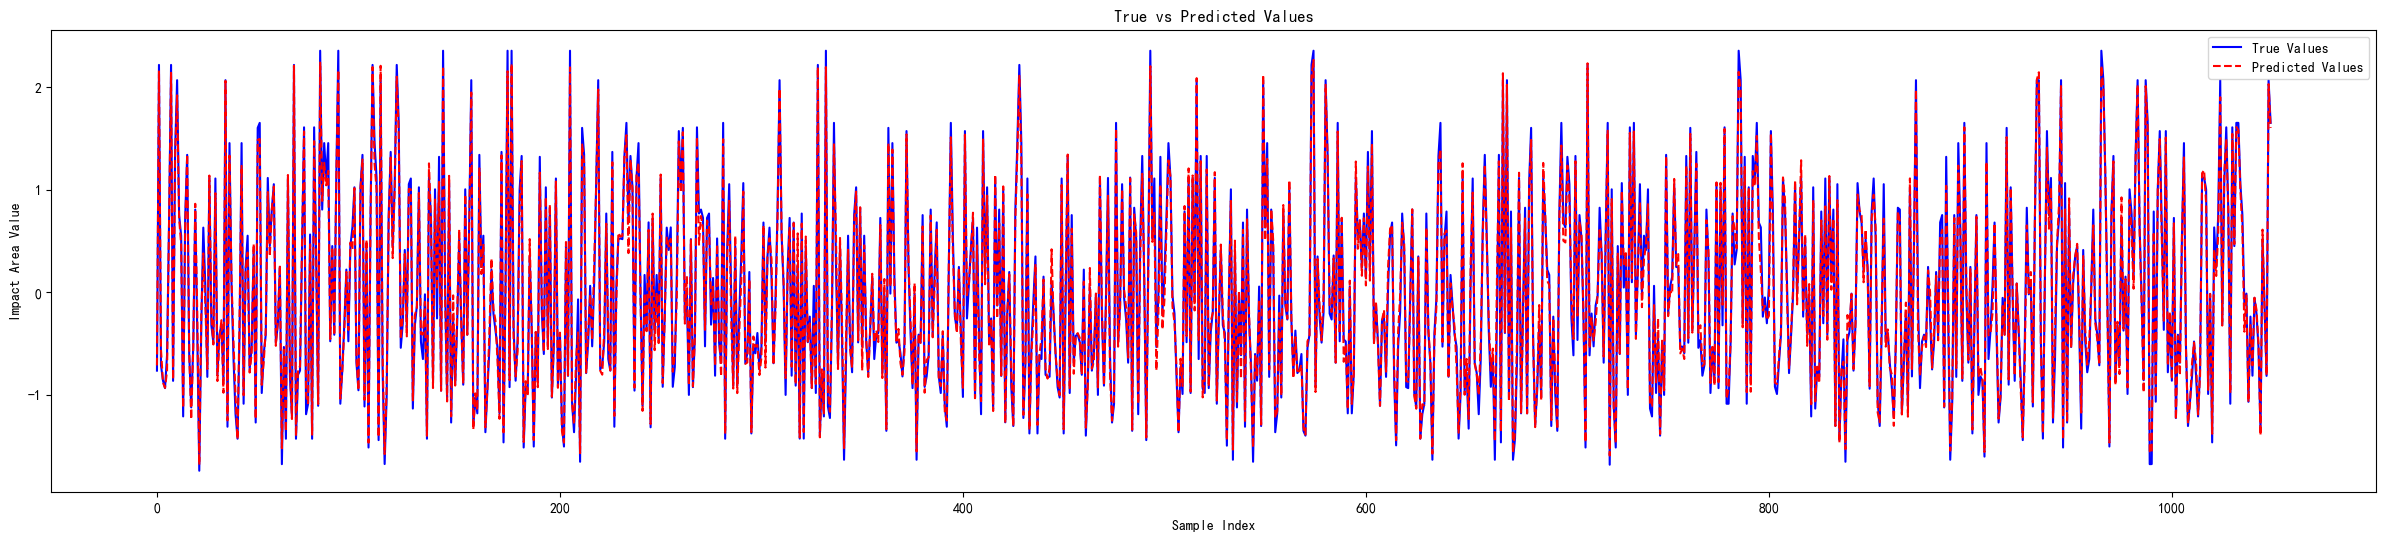

In [10]:
# 绘制预测值和真实值对比图
plt.figure(figsize=(30, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Impact Area Value')
plt.legend()
plt.show()